# Model Evaluation

## Importing Dependencies

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader
import pandas as pd

try:
    import mnist_asl_letters_classification.utils.visualization as mist_viz
  import utils.visualization as viz
  from mnist_asl_letters_classification.models.asl_classifier_cnn_model import ASLAlphabetClassifier
  from mnist_asl_letters_classification.scripts.datasets.asl_mnist_dataset import ASLAlphabetMNISTDataset
  from utils.transforms import asl_mnist_test_transforms
  from utils.training_utils import get_predictions
except:
  print("Utils not found.")

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

## Data Loading 

In [3]:
test_data_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "sign_mnist_test.csv"))

if not os.path.exists(test_data_path):
  print("Data not found.")

In [4]:
test_df = pd.read_csv(test_data_path)

test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
device == torch.device("cpu")

True

In [6]:
num_classes = 26
BATCH_SIZE = 16
NUM_WORKERS = torch.cuda.device_count() if device == torch.device("cuda") else 0

test_dataset = ASLAlphabetMNISTDataset(test_df, transforms=asl_mnist_test_transforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## Model Loading

In [7]:
current_dir = os.getcwd()
saved_model_path = os.path.abspath(os.path.join(current_dir, "..", "models", "checkpoints", "asl_mnist_classifier_cnn1.pth"))

model = ASLAlphabetClassifier(in_channels=1, num_classes=num_classes)
model.load_state_dict(torch.load(saved_model_path, map_location=device))
model.to(device)

ASLAlphabetClassifier(
  (conv_block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv_block2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv_block3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=32, out_features=26, bias=True)
)

## Predictions

In [8]:
y_true, y_preds = get_predictions(model, test_dataloader, device)

In [9]:
class_names = [chr(i) for i in range(65, 91)]
class_names.remove("J")
class_names.remove("Z")

print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


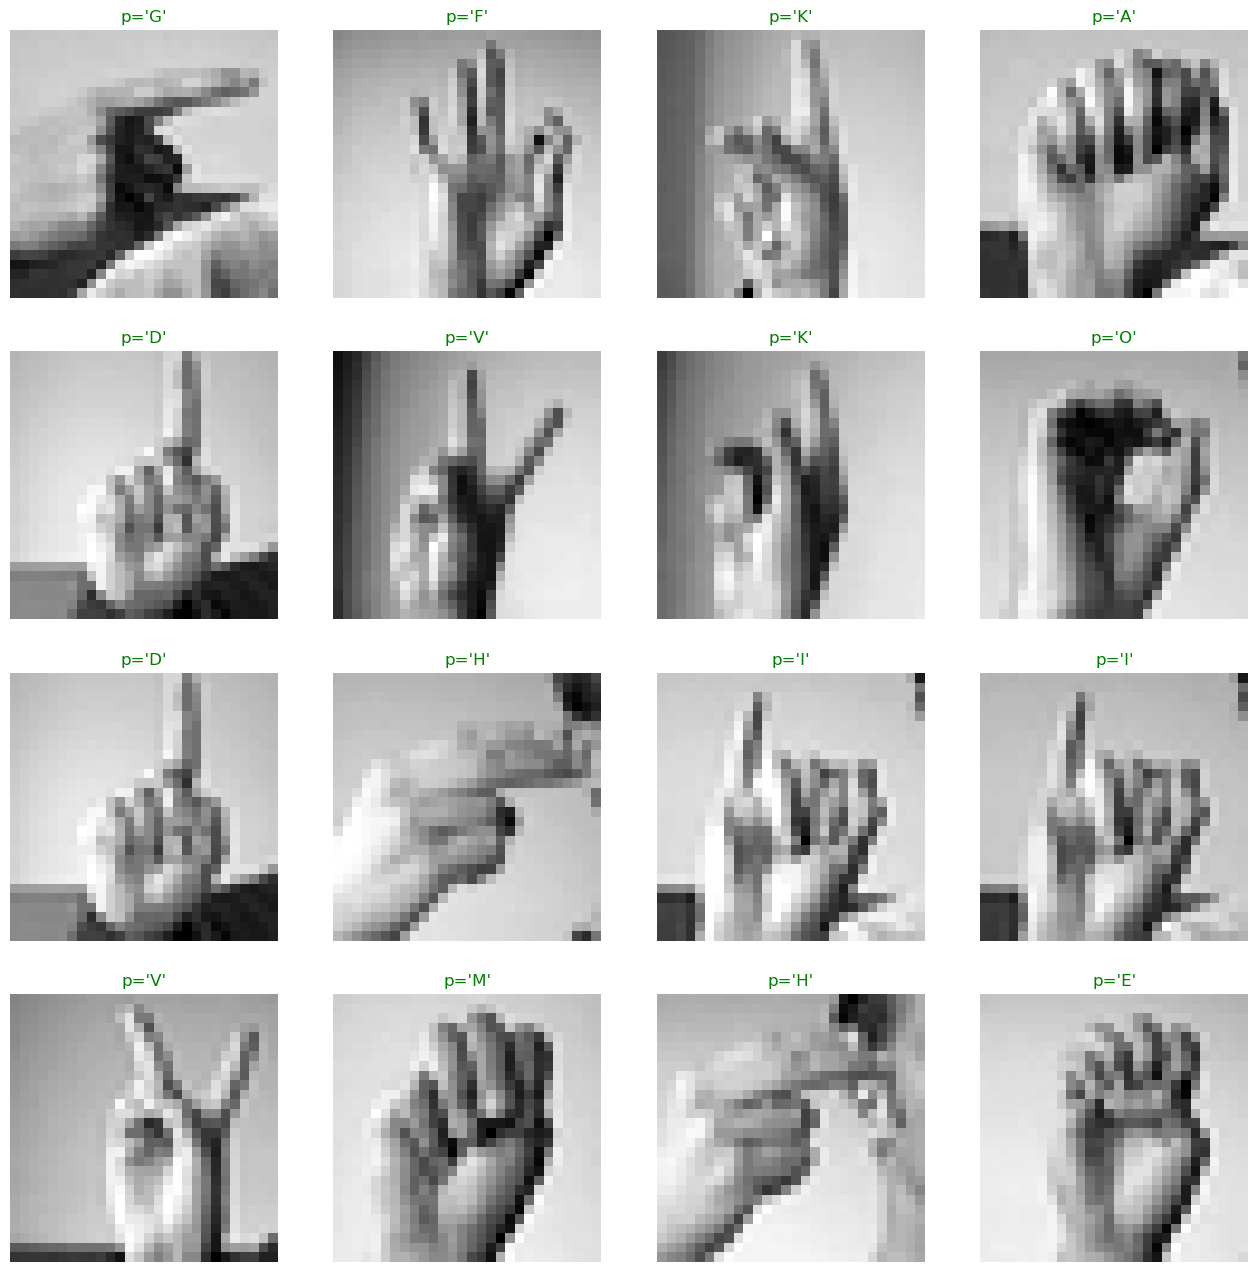

✅ Figure saved.


In [ ]:
fig = mnist_viz.visualize_asl_mnist_preds(model, test_dataloader, device, n_images=16)
viz.save_figure(fig, "asl_mnist_preds", dirname="model1")

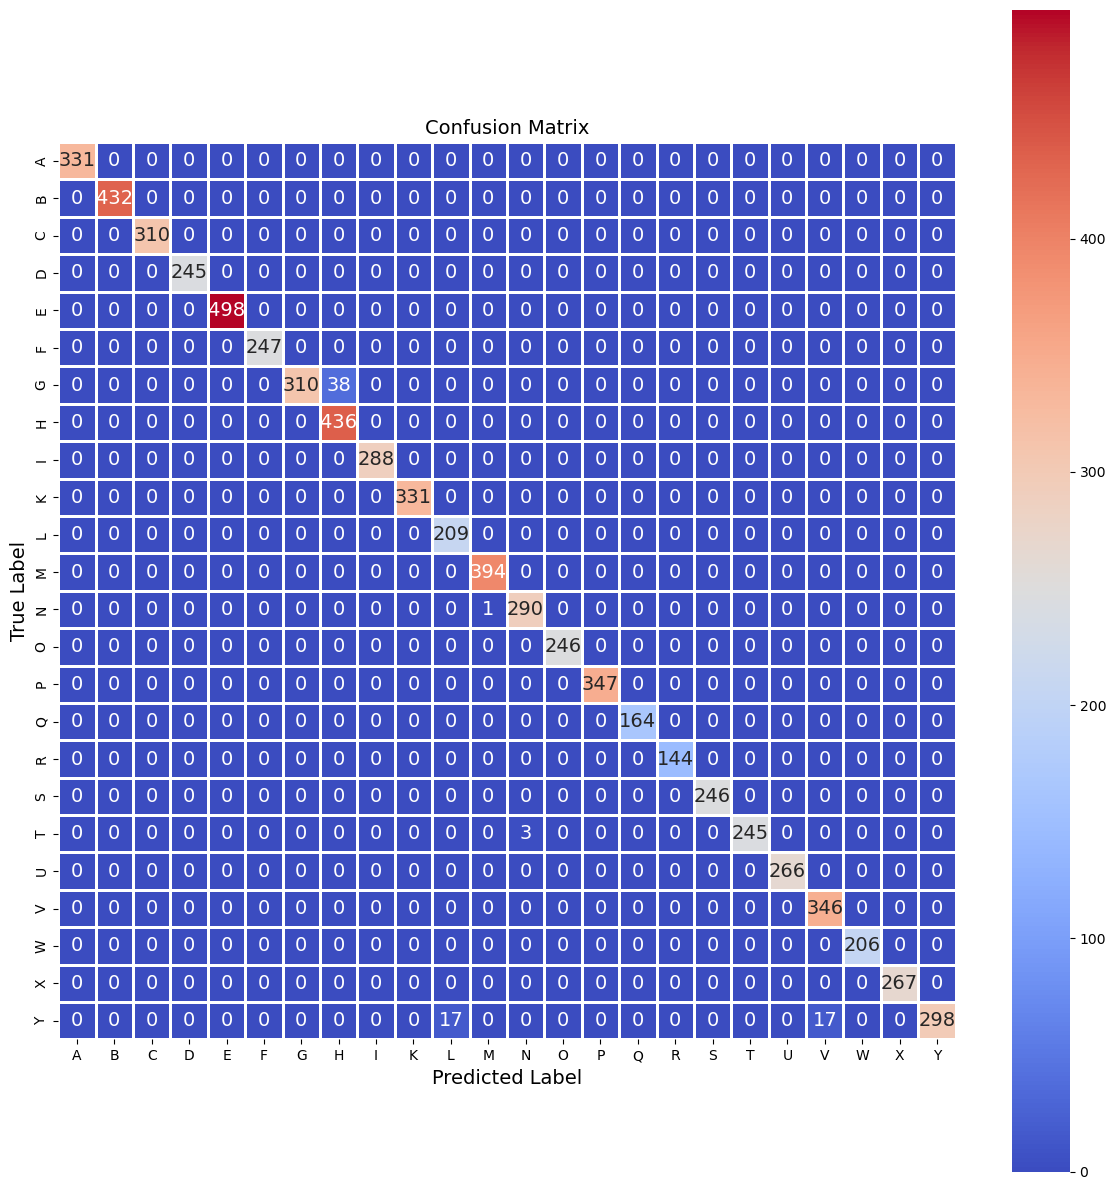

✅ Figure saved.


In [ ]:
conf_matrix = viz.plot_confusion_matrix(y_true, y_preds, class_names)
viz.save_figure(conf_matrix, "confusion_matrix", "model1")

In [12]:
import torchmetrics

y_true = torch.tensor(y_true).to(device)
y_preds = torch.tensor(y_preds).to(device)

f1 = torchmetrics.functional.f1_score(y_preds, y_true, task="multiclass", num_classes=num_classes, average="weighted")
acc = torchmetrics.functional.accuracy(y_preds, y_true, task="multiclass", num_classes=num_classes, average="weighted")
recall = torchmetrics.functional.recall(y_preds, y_true, task="multiclass", num_classes=num_classes, average="weighted")
precision = torchmetrics.functional.precision(y_preds, y_true, task="multiclass", num_classes=num_classes, average="weighted")

print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

F1-Score: 0.9893
Accuracy: 0.9894
Recall: 0.9894
Precision: 0.9901
